In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prospect.utils.obsutils import fix_obs
import seaborn as sns
sns.set_context('notebook')

from agnfinder.prospector import visualise, main, cpz_builders

In [3]:
def get_samples(sample_loc, drop=1000):
    assert os.path.isfile(sample_loc)
    with h5py.File(sample_loc, 'r') as f:
        return f['samples'][drop:]

In [6]:
# run_dir = '/home/mike/repos/agnfinder/results/qso_fixed_inclination_bigger_agn'
run_dir = '/home/mike/repos/agnfinder/results/qso_wide_priors_fixed_inclination'

files = os.listdir(run_dir)
sample_files = [x for x in files if 'multinest_samples' in x]

# qso_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'qso_wide_priors' in x]
agn_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'agn_wide_priors' in x]
starforming_sample_locs = [os.path.join(run_dir, x) for x in sample_files if 'starforming_wide_priors' in x]

# assert qso_sample_locs
assert agn_sample_locs
assert starforming_sample_locs

In [7]:
samples_by_class = {
#     'qso': qso_sample_locs,
    'agn': agn_sample_locs,
    'starforming': starforming_sample_locs
}

In [8]:
free_params = ['mass', 'dust2', 'tage', 'tau', 'agn_mass', 'agn_eb_v', 'agn_torus_mass']
# WARNING this is hardcoded, will need to change should model change

In [ ]:
#  samples_by_class['qso']

In [9]:
# galaxy_classes = ['qso', 'agn', 'starforming']
galaxy_classes = ['agn', 'starforming']

In [10]:
data = []
for galaxy_class in galaxy_classes:
    for sample_loc in samples_by_class[galaxy_class]:
        samples = get_samples(sample_loc)
        temp_df = pd.DataFrame(samples, columns=free_params)
        temp_df['galaxy_class'] = galaxy_class
        data.append(temp_df)
raw_df = pd.concat(data).reset_index()
del data

In [11]:
raw_df.sample(5)

,index,mass,dust2,tage,tau,agn_mass,agn_eb_v,agn_torus_mass,galaxy_class
195863,860,1.666335e+08,1.767141,0.124402,0.351112,2.014557,0.495729,0.392346,starforming
142484,49963,1.955902e+09,0.018220,2.231987,0.505079,0.034292,0.493363,0.000011,agn
61023,3179,1.925458e+09,0.084007,7.589907,8.827460,0.042530,0.495394,0.000474,agn
114421,21900,2.048099e+09,0.022285,2.681417,0.683094,0.032308,0.486901,0.000023,agn
43651,5685,1.072620e+09,0.002288,4.947755,0.931743,0.012805,0.490251,0.000015,agn


In [12]:
limits = {
    'mass': [0., 1e11],
    'dust2': [0., 2.],
    'tage': [0., 15.],
    'tau': [0., 6.],
    'agn_mass': [0, 50],
    'agn_eb_v': [0., 0.5],
    'agn_torus_mass': [0., 50]
}

df = raw_df.copy()
for col, lims in limits.items():
    df = df[(df[col] > lims[0]) & (df[col] < lims[1])]


In [13]:
len(df), len(raw_df)

(185243, 218016)

In [14]:
log_params = ['mass']

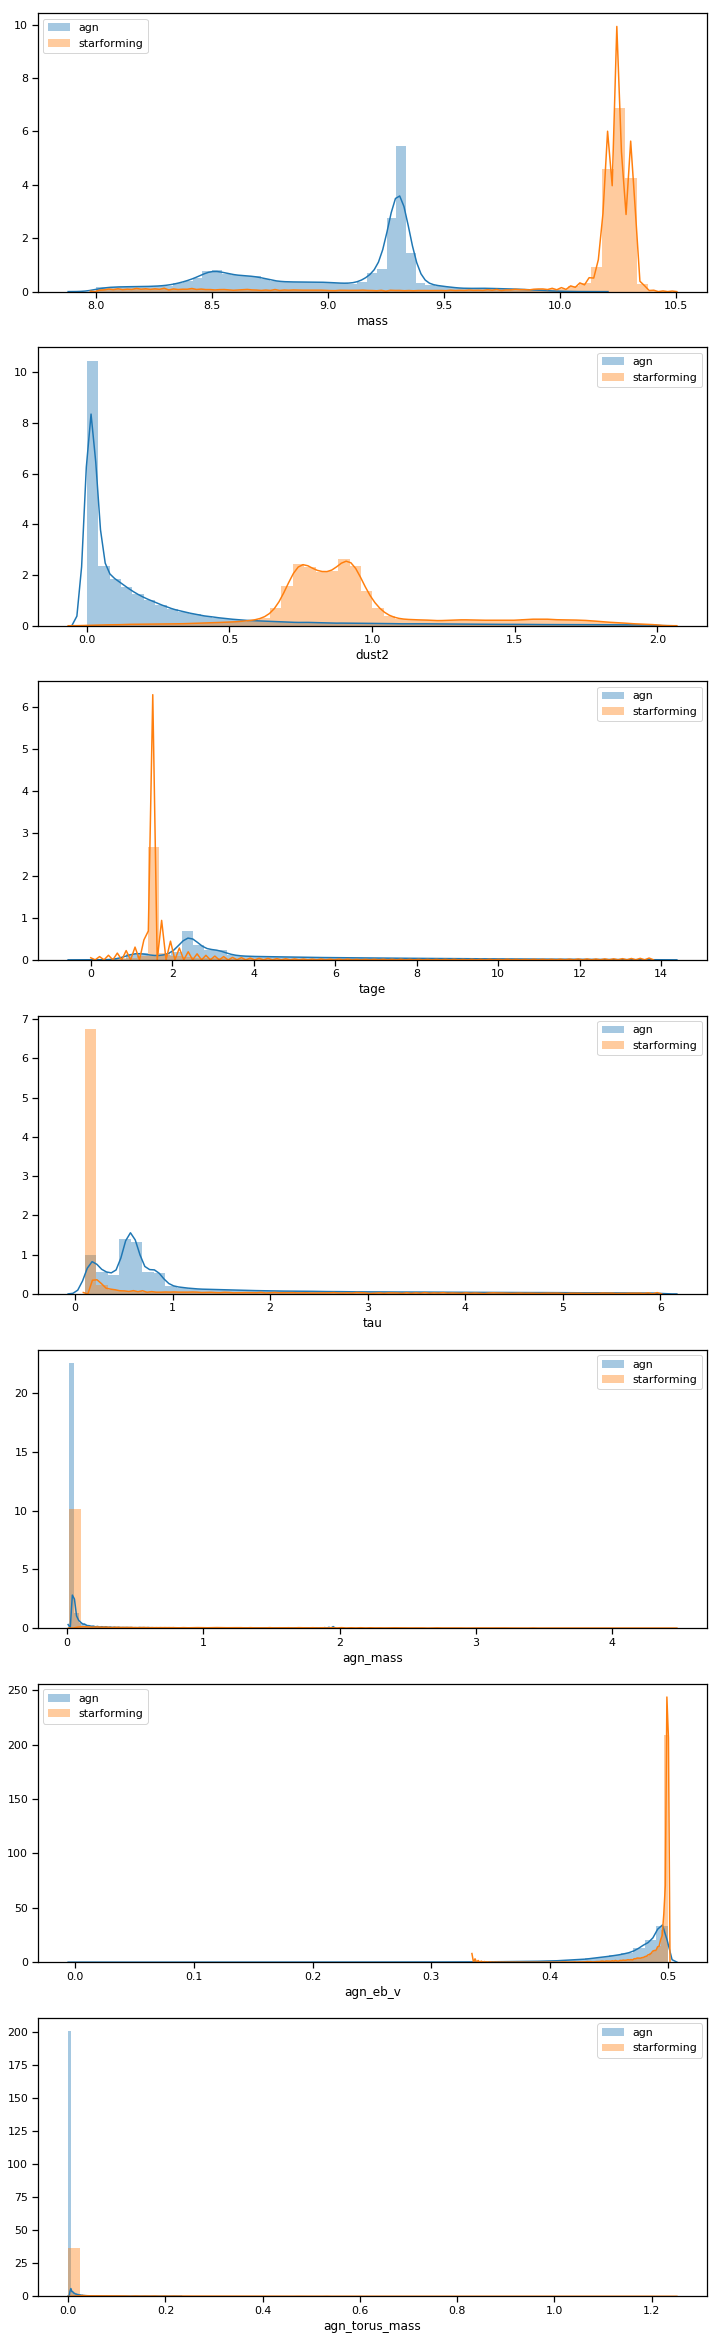

In [15]:
nrows = len(free_params)
fig, axes = plt.subplots(nrows=nrows, figsize=(12, 6 * nrows))
for ax_n, ax in enumerate(axes):
    feature = free_params[ax_n]
    #  _ = sns.catplot(data=df, x='galaxy_class', y=feature, kind="violin", ax=ax)
    for galaxy_class in galaxy_classes:
        values = df[df['galaxy_class'] == galaxy_class][feature]
        if feature in log_params:
            values = np.log10(values)
        sns.distplot(values, label=galaxy_class, ax=ax)
        ax.legend()
#     ax.set_ylim(limits[feature])
# print('done')

No handles with labels found to put in legend.


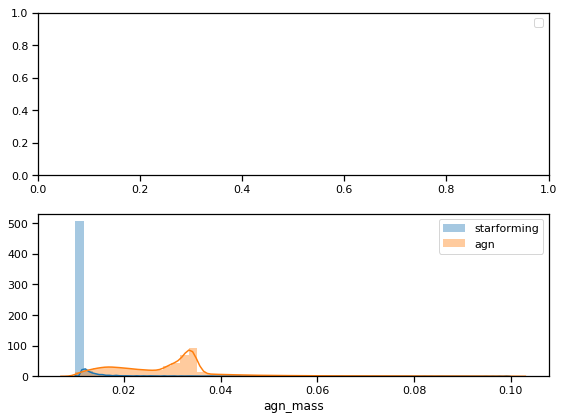

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
# for galaxy_class in ['qso']:
#     sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_mass'] < 10.)]['agn_mass'], label=galaxy_class, ax=axes[0])
for galaxy_class in ['starforming', 'agn']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_mass'] < .1)]['agn_mass'], label=galaxy_class, ax=axes[1])
axes[0].legend()
axes[1].legend()
fig.tight_layout()

In [17]:
sf = df[df['galaxy_class'] =='starforming']

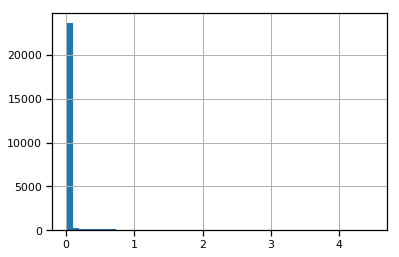

In [18]:
sf['agn_mass'].hist(bins=50)

In [19]:
sf['agn_mass'].median()  # i.e. 1e-3, the minimum

0.010081908

In [20]:
sf['agn_eb_v'].median()  # i.e. 5, the max

0.4987109

In [21]:
sf['agn_torus_mass'].median()  # i.e. 1e-3, the minimum

0.00063325826

No handles with labels found to put in legend.


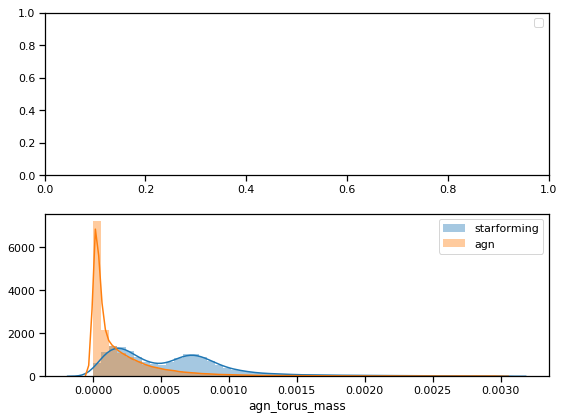

In [22]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
# for galaxy_class in ['qso']:
#     sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_torus_mass'] < 10.)]['agn_torus_mass'], label=galaxy_class, ax=axes[0])
for galaxy_class in ['starforming', 'agn']:
    sns.distplot(df[(df['galaxy_class'] == galaxy_class) & (df['agn_torus_mass'] < .003)]['agn_torus_mass'], label=galaxy_class, ax=axes[1])
axes[0].legend()
axes[1].legend()
fig.tight_layout()